In [42]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount ('/content/drive')

datasheet = '/content/drive/My Drive/Datasheet/DDoS/dataset_sdn.csv'
df = pd.read_csv(datasheet)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [3]:
df.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label'],
      dtype='object')

**PREPROCESSING PIPELINE**

In [4]:
Features = [
    'dt','dur','dur_nsec','tot_dur','pktrate','Protocol','port_no','tx_kbps','rx_kbps','tot_kbps'
]
df_clean = df[Features]

In [5]:
from sklearn.model_selection import train_test_split

X = df_clean
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_cat = ['Protocol']
encoder_transform = encoder

In [8]:
numeric_features = ['dt','dur','dur_nsec','tot_dur','pktrate','port_no','tx_kbps','rx_kbps','tot_kbps']

In [9]:
scaler = StandardScaler()
numeric_feat = numeric_features
numeric_transform = scaler

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat',encoder_transform, encoder_cat),
        ('num', numeric_transform, numeric_feat)
    ],
    remainder = 'drop'
)

In [11]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [12]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators= 200,
    learning_rate = 0.1,
    max_depth= 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    scale_pos_weight = scale_pos_weight,
    random_state = 42,
    n_jobs= -1,
    eval_metrics= 'logloss'

)

In [13]:
from xgboost import XGBClassifier

XG_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', xgb_clf)
])

**HYPERPARAMETER TUNING (GridSearchCV)**

In [14]:
param_grid = {
    'classifier__max_depth' : [4,6,8],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0]
}

In [19]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
random_search = RandomizedSearchCV(
    XG_pipeline,
    param_grid,
    cv = cv,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose=2
)

In [22]:
# Jalankan GridSearchCV
random_search.fit(X_train, y_train)

print("Best Parameters", random_search.best_params_)
print("Best CV Score :", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:08:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters {'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.8}
Best CV Score : 0.9984282766816166


**EVALUATE MODEL**

In [23]:
best_model = random_search.best_estimator_

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prediksi di training set untuk mengetahui overfit sebuah model
y_train_pred = best_model.predict(X_train)

# Hitung akurasi
train_acc = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_acc)

Training Accuracy: 0.9998977740294922


In [25]:
# Evaluate model menggunakan datasheet test
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15885
           1       1.00      1.00      1.00     10202

    accuracy                           1.00     26087
   macro avg       1.00      1.00      1.00     26087
weighted avg       1.00      1.00      1.00     26087



In [26]:
print('Akurasi :', acc)

Akurasi : 0.9986200022999961


In [28]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X, y, cv=kf)
print(scores.mean())


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:13:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:14:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:14:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:14:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:14:07] WARNING: /workspace/src/learner

0.9988020508888782


In [29]:
# Korelasi fitur dengan label

corr = df[Features + ['label']].select_dtypes(include=['number']).corr()['label'].sort_values(ascending=False)
print(corr)


label       1.000000
pktrate     0.088013
dur_nsec    0.029064
port_no    -0.004734
tx_kbps    -0.006297
rx_kbps    -0.006714
tot_kbps   -0.008748
dur        -0.098479
tot_dur    -0.098491
dt         -0.110126
Name: label, dtype: float64


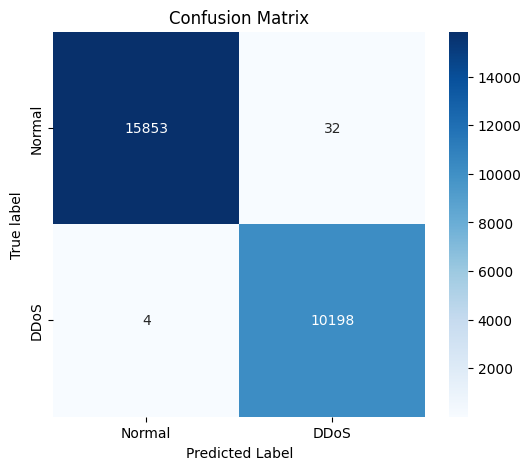

In [30]:
# Grafik evaluasi confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

label = ['Normal','DDoS']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = label,
            yticklabels = label)
plt.xlabel('Predicted Label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
preprocessor  = best_model.named_steps['preprocess']
model = best_model.named_steps['classifier']

# Nama kolom dari masing-masing transformer
categorical_features = ['Protocol']
numeric_features = ['dt','dur','dur_nsec','tot_dur','pktrate','port_no','tx_kbps','rx_kbps','tot_kbps']

# Pastikan preprocessor sudah fit (otomatis sudah karena RandomSearchCV fit)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
num_features = numeric_features

feature_names = list(cat_features) + list(num_features)

In [39]:
# Top Fitur XGBoost
import matplotlib.pyplot as plt

importances = model.feature_importances_

feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_importance_df.head(15))

          feature  importance
0   Protocol_ICMP    0.294107
7         pktrate    0.240132
1    Protocol_TCP    0.178741
2    Protocol_UDP    0.129716
6         tot_dur    0.047747
3              dt    0.037362
11       tot_kbps    0.028058
4             dur    0.026229
5        dur_nsec    0.009906
10        rx_kbps    0.006036
9         tx_kbps    0.001095
8         port_no    0.000871


In [40]:
import joblib
from google.colab import files

joblib.dump(best_model, 'XGBoost_DetectionDDoS.pkl')
files.download('XGBoost_DetectionDDoS.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>